# Marvel Character

https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data



In [1]:
import time

from fastai.vision.all import *
from fastcore.all import *
from fastdownload import download_url


## Setup/Configuration

In [2]:
data_path = Path("../data")
model_path = Path("../models")


## Utilities

In [3]:
def search_images(term, max_images=200):
    url = "https://duckduckgo.com/"
    res = urlread(url, data={"q": term})
    searchObj = re.search(r"vqd=([\d-]+)\&", res)
    requestUrl = url + "i.js"
    params = dict(l="us-en", o="json", q=term, vqd=searchObj.group(1), f=",,,", p="1", v7exp="a")
    urls, data = set(), {"next": 1}

    while len(urls) < max_images and "next" in data:
        data = urljson(requestUrl, data=params)
        urls.update(L(data["results"]).itemgot("image"))
        requestUrl = url + data["next"]
        time.sleep(0.2)

    return L(urls)[:max_images]


## Step 1: Get data

### Let's start by downloading a Marvel character

In [4]:
urls = search_images("Marvel Character full body picture", max_images=1)
urls[0]


'https://i.pinimg.com/originals/7c/d7/82/7cd782fc3edc8c4a76d91ea0dcb48b99.png'

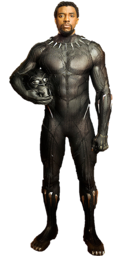

In [5]:
dest = data_path / "_marvel_example.jpg"
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


### Let's download a DC character

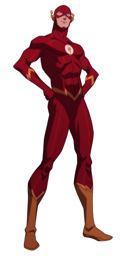

In [6]:
dest = data_path / "_dc_example.jpg"
download_url(search_images("DC Character full body picture", max_images=1)[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


### Create a full dataset

In [7]:
searches = ("marvel", "Marvel Character full body picture"), ("dc", "DC Character full body picture")

for o in searches:
    dest = data_path / o[0]

    # if the path already exists, assume we already fetched the images for this category
    if dest.exists():
        continue

    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{o[1]} photo"))
    resize_images(dest, max_size=400, dest=dest)


In [8]:
failed = verify_images(get_image_files(data_path))
failed.map(Path.unlink)
len(failed)


0

## Step 2: Build your `DataLoaders`

In [9]:
def is_marvel(img):
    return 1.0 if img.parent.name.lower().startswith("marvel") else 0.0


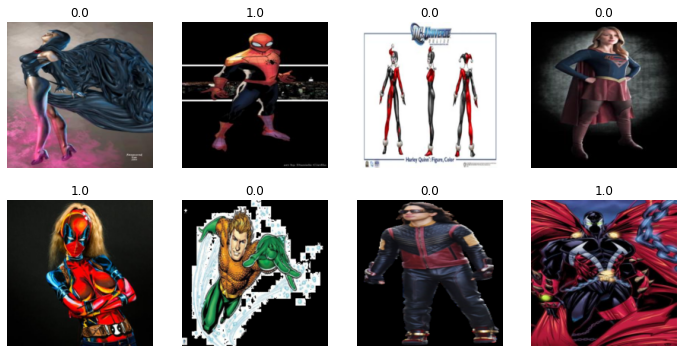

In [10]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    get_y=is_marvel,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[Resize(192, method="squish")],
)

dls = dblock.dataloaders(data_path)

dls.show_batch(max_n=8)


TODO: Explain `DataBlock` above

## Step 3: Train with a `Learner`

In [11]:
learn = vision_learner(dls, resnet18, metrics=rmse, y_range=(0, 1))
learn.path = model_path
print(learn.loss_func)


FlattenedLoss of MSELoss()


TODO: Explain metrics, y_range and loss_func above

In [12]:
learn.fine_tune(3, 1e-3)


TODO: Explain `Learner.export`

In [13]:
learn.export(fname="export.pkl")


## Inference

TODO: Explain `load_learner`

In [14]:
inf_learn = load_learner(model_path / "export.pkl")


TODO: Explain what predict returns and why we write a custom predict function

In [15]:
inf_learn.predict(PILImage.create(data_path / "_dc_example.jpg"))


((0.11695774644613266,), TensorBase([0.1170]), TensorBase([0.1170]))

In [16]:
def predict(img):
    pred, _, _ = learn.predict(img)
    return {"is_marvel": pred[0]}


### Test

Probability of being a Marvel character: 41.55%


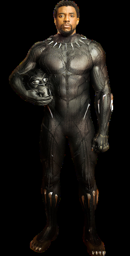

In [17]:
test_img = PILImage.create(data_path / "_marvel_example.jpg")
res_d = predict(test_img)

print(f"Probability of being a Marvel character: {res_d['is_marvel']*100:.2f}%")
test_img.to_thumb(256, 256)


Probability of being a Marvel character: 11.70%


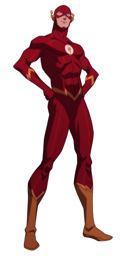

In [18]:
test_img = PILImage.create(data_path / "_dc_example.jpg")
res_d = predict(test_img)

print(f"Probability of being a Marvel character: {res_d['is_marvel']*100:.2f}%")
test_img.to_thumb(256, 256)
